# Machine Translation
  1. Using word alignment 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading Dataset
ftr=open('/content/drive/My Drive/Projects/Machine Translation/small_vocab_fr','r')
ftrain=ftr.read()
ftrain=ftrain.split('\n')
ftr.close()
etr=open('/content/drive/My Drive/Projects/Machine Translation/small_vocab_en','r')
etrain=etr.read()
etrain=etrain.split('\n')
etr.close()

In [3]:
# Text preprocessing
# Checking the sequence of wordsfor padding.

import tensorflow as tf
tokenizer_french=tf.keras.preprocessing.text.Tokenizer(num_words=10000 , oov_token='<oov>')
tokenizer_french.fit_on_texts(ftrain)
fseq=tokenizer_french.texts_to_sequences(ftrain)

tokenizer_eng=tf.keras.preprocessing.text.Tokenizer(num_words=10000,oov_token='<oov>')
tokenizer_eng.fit_on_texts(etrain)
eseq=tokenizer_eng.texts_to_sequences(etrain)


mean length for french sentence =12.423528046365542, for english=11.261364707930452
STD for french sentence length =2.867754490213468, for english=3.172094299930908


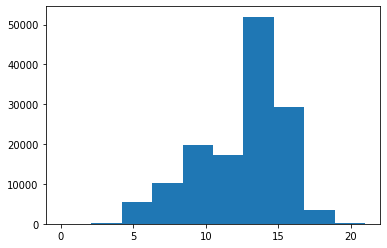

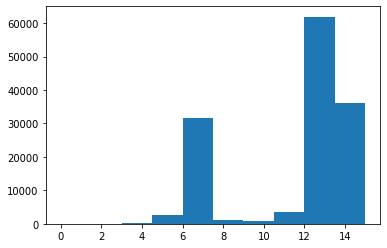



Max len for french =21 , for english 15


In [4]:
# Checking the length of sentences
fr=[len(i) for i in fseq]
en=[len(i) for i in eseq]
print('mean length for french sentence ={}, for english={}'.format(np.mean(fr),np.mean(en)))
print('STD for french sentence length ={}, for english={}'.format(np.std(fr),np.std(en)))

import matplotlib.pyplot as plt
plt.hist(fr,bins=10)
plt.show()
plt.hist(en,bins=10)
plt.show()

# max len \
print('\n\nMax len for french ={} , for english {}'.format(max(fr),max(en)))

In [5]:
# We can pad the sequence upto its max length

fpad=tf.keras.preprocessing.sequence.pad_sequences(
    fseq, maxlen=None, dtype='int32', padding='post', truncating='post',
    value=0.0)

epad=tf.keras.preprocessing.sequence.pad_sequences(
    eseq, maxlen=None, dtype='int32', padding='post', truncating='post',
    value=0.0)


# Lets check the vocab length

print('Length of french vocab {} and english vocab {}'.format(len(tokenizer_french.word_index),len(tokenizer_eng.word_index)))

Length of french vocab 345 and english vocab 200


In [6]:
# Add pad and start word.

# In english vocab add <pad>  token 
tokenizer_eng.word_index['<pad>'] = 0


# In french vocab add <pad> and <start> token 
tokenizer_french.word_index['<pad>']=0
tokenizer_french.word_index['<start>'] = 346

print('Now the size of the vocab is now, for french {} and eng {}'.format(len(tokenizer_french.word_index),len(tokenizer_eng.word_index)))

# Create reverse Dictionary 

fr_itow={i:j for j,i in tokenizer_french.word_index.items()}
en_itow={i:j for j,i in tokenizer_eng.word_index.items()}


Now the size of the vocab is now, for eng 347 and french 201


In [13]:
# Creating train and validation set 

# Train
train_input=epad[:130000].reshape((130000,15))
train_output=fpad[:130000].reshape((130000,21))
# val
val_input=epad[130000:].reshape((7861,15))
val_output=fpad[130000:].reshape((7861,21))

# Attention Mechanism

Implementing the paper's archetacture without the alignment layer that is without attention. 

Paper- NEURAL MACHINE TRANSLATION
BY JOINTLY LEARNING TO ALIGN AND TRANSLATE
by - Dzmitry Bahdanau


  1. The Encoder -Decoder architecture is as follows-

  Encoder = Input --> Embedding with 16 vector size ---> Bi-Directional lstm with 100 units.
    
  Decoder = Output --> Bidirectional lstm 100 units--> softmax Dense
    

In [ ]:
x=tf.constant([i for i in range(6)])
x=tf.reshape(x,shape=(2,1,3))
y=tf.constant([i for i in range(24)])
y=tf.reshape(y,shape=(2,4,3))
tf.print(x,'\n\n',y)

[[[0 1 2]]

 [[3 4 5]]] 

 [[[0 1 2]
  [3 4 5]
  [6 7 8]
  [9 10 11]]

 [[12 13 14]
  [15 16 17]
  [18 19 20]
  [21 22 23]]]


In [19]:
# Encoder

# Building encoder with bidirectional lstm
tf.keras.backend.clear_session()

class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder,self).__init__()
    self.em=tf.keras.layers.Embedding(201,16)
    self.drop=tf.keras.layers.Dropout(0.2)
    self.drop1=tf.keras.layers.Dropout(0.2)
    self.enc=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(15,activation='relu',return_state=True,return_sequences=True))
    #self.enc1=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(15,activation='relu',return_state=True))

  def call(self,inputs):
    emb=self.em(inputs)
    d1=self.drop(emb)
    en1=self.enc(d1)
    #d2=self.drop1(en1[0])
    #en2=self.enc1(d2)
    #out=tf.reshape(en1[0],(en1[0].shape[0],1,30))
    return en1[0]

enc=Encoder()

In [21]:
# Testing the input
# Required output shape==> (batch,maxlen,hidden_state)  ==(2,15,30)
inp=train_input[:2]
out=enc(inp)
assert out.shape==(2,15,30), 'Somthing went wrong'
print('looks fine')


Everything is fine


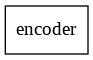

In [22]:
tf.keras.utils.plot_model(enc)

In [32]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.w1=tf.keras.layers.Dense(units)
    self.w2=tf.keras.layers.Dense(units)
    self.v=tf.keras.layers.Dense(1)
    self.activation = tf.keras.layers.Activation('tanh')
    self.activation1 = tf.keras.layers.Activation('softmax')

  def call(self,dec_hid,enc_out):
    x=self.w1(dec_hid)+self.w2(enc_out)
    x=self.activation(x)
    x=self.v(x)
    wghts=self.activation1(x)
    context_vector=wghts*enc_out
    context_vector=tf.reduce_sum(context_vector,axis=1)
    return wghts,context_vector


units=21
at=BahdanauAttention(21)

In [36]:
#Testing bahdanau's attention word alignment

init=tf.random_normal_initializer()
dec_hid=tf.Variable(initial_value=init(shape=(2,1,21),dtype=tf.float32))
enc_out=out

# Expected weights output shape ==> (batch,maxlen,1) ==> (2,15,1)
# Expected context vector output shape ==> (batch,hidden) ==> (2,15)
weights,context_vector=at(dec_hid,enc_out)
assert weights.shape==(2,15,1), 'Somthing went wrong with weights'
assert context_vector.shape==(2,30), 'Somthing went wrong with context_vector'
print('looks fine')

# Printing the weights
weights

looks fine


<tf.Tensor: shape=(2, 15, 1), dtype=float32, numpy=
array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)>

In [37]:
# Decoder
# As we are applying teacher forcing, we can't use Bidirectional layer

class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder,self).__init__()
    self.em=tf.keras.layers.Embedding(347,16)
    self.drop=tf.keras.layers.Dropout(0.2)
    #self.drop1=tf.keras.layers.Dropout(0.2)
    self.dec=tf.keras.layers.GRU(21,activation='relu',return_state=True,return_sequences=True)
    #self.dec1=tf.keras.layers.GRU(21,activation='relu',return_state=True,return_sequences=True)
    self.dense=tf.keras.layers.Dense(347,activation='sigmoid')
    self.attention=BahdanauAttention(21)

  def call(self,enc_out,dec_hidden,inp):
    x=self.em(inp)
    weights,context_vector=self.attention(dec_hidden,enc_out)
    context_vector=tf.reshape(context_vector,shape=(context_vector.shape[0],1,context_vector.shape[-1]))
    concat=tf.keras.layers.concatenate([x,context_vector,dec_hidden],axis=2)
    #drop=self.drop(concat)
    dec_out,dec_hidden=self.dec(concat)
    #drop1=self.drop1(dec_out)
    #dec_hidden2=tf.reshape(dec_hidden2,shape=(dec_hidden2.shape[0],1,dec_hidden2.shape[-1]))
    #concat1=tf.keras.layers.concatenate([dec_out,dec_hidden2],axis=2)
    #drop1=self.drop1(concat1)
    #dec_out2,dec_hidden2=self.dec1(drop1)
    pred=self.dense(dec_out)
    return dec_hidden,pred,weights

dec=Decoder()

In [41]:
#Testing decoder

# Output shapes should be : dec_hidden=(batch,1,hidden)==>(2,1,21),weights=(batch,maxlen,1)==>(2,15,1)
#                           pred=(batch,1,vocab)==>(2,1,347) 

inp=np.array([346,346]).reshape((2,1))
dec_hidden,pred,weights=dec(enc_out,dec_hid,inp)

assert weights.shape==(2,15,1), 'Somthing went wrong with weights'
assert dec_hidden.shape==(2,21), 'Somthing went wrong with decoder hidden'
assert pred.shape==(2,1,347), 'Somthing went wrong with prediction vector'

print('looks good')

looks good


In [42]:
# Creating required APIs
optimizer = tf.keras.optimizers.Adam()
loss_ = tf.keras.losses.SparseCategoricalCrossentropy()
acc=tf.keras.metrics.Accuracy()

In [48]:
def train_step(inp,out):
  batch=inp.shape[0]
  initializer=tf.random_normal_initializer(seed=33)
  dec_hidden=tf.Variable(initial_value=initializer(shape=(batch,1,21),dtype=tf.float32))
  dec_input=np.array([346]*batch).reshape(batch,1)
  pred_out=[]
  wghts=[]
  with tf.GradientTape() as tape:
    enc_out=enc(inp)
    for i in range(out.shape[1]):
      dec_hidden,pred,weights=dec(enc_out,dec_hidden,dec_input)
      dec_input=out[:,i].reshape((batch,1))
      dec_hidden=tf.reshape(dec_hidden,shape=(batch,1,dec_hidden.shape[-1]))
      pred_out.append(pred)
      wghts.append(weights)
    ypred=tf.concat(pred_out,axis=1)
    weight=tf.concat(wghts,axis=2)
    ls=loss_(out,ypred)

  variables = enc.trainable_variables + dec.trainable_variables
  gradients = tape.gradient(ls, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return ls,ypred,weight

In [49]:
# checking if training is actually appening or not

# Test 1
inp=train_input[:30]
out=train_output[:30]

ls,ypred,weights=train_step(inp,out)
print(ls)

tf.Tensor(5.8468494, shape=(), dtype=float32)


In [50]:
# Test 2
inp=train_input[30:60]
out=train_output[30:60]

ls,ypred,weights=train_step(inp,out)
print(ls)

tf.Tensor(5.8445435, shape=(), dtype=float32)


In [51]:
# Test 2
inp=train_input[60:90]
out=train_output[60:90]

ls,ypred,weights=train_step(inp,out)
print(ls)

tf.Tensor(5.841215, shape=(), dtype=float32)


In [52]:
# We  can see that loss is reduced
# Lets define predict to have a validation accuracy

def predict(inp):
  batch=inp.shape[0]
  initializer=tf.random_normal_initializer(seed=33)
  dec_hidden=tf.Variable(initial_value=initializer(shape=(batch,1,21),dtype=tf.float32))
  dec_input=np.array([345]*batch).reshape(batch,1)
  pred_out=[]
  wghts=[]
  enc_out=enc(inp)
  for i in range(21):
    dec_hidden,pred,weights=dec(enc_out,dec_hidden,dec_input)
    dec_input=tf.reshape(tf.math.argmax(pred,axis=2),shape=(batch,1))
    dec_hidden=tf.reshape(dec_hidden,shape=(batch,1,dec_hidden.shape[-1]))
    pred_out.append(pred)
    wghts.append(weights)
  weight=tf.concat(wghts,axis=2)
  ypred=tf.concat(pred_out,axis=1)
  return ypred,weight


In [55]:
import time

In [53]:
# Testing the predict function

# Output shapes should be : weights=(batch,maxlen_inp,maxlen_output)==>(5,15,21)
#                           ypred=(batch,21,vocab)==>(5,21,347) 

inp=train_input[:5]
ypred,weight=predict(inp)
assert weight.shape==(5,15,21), 'Somthing went wrong with weights'
assert ypred.shape==(5,21,347) , 'Somthing went wrong with prediction vector'

print('looks good')

looks good


In [62]:
# Lets train the model for 20 epochs

# Training...
trn=tf.data.Dataset.from_tensor_slices((train_input,train_output)).batch(128)
epochs=20
print('Training starts ...')
for j in range(epochs):
  t=time.time()
  print('\n\n---Epoch {}  :----'.format(j))
  a=[]
  l=[]
  for i,(inp,out) in enumerate(trn):
    inp=inp.numpy()
    out=out.numpy()
    ls,ypred,weight=train_step(inp,out)
    ypred=tf.math.argmax(ypred,axis=2)
    ypred=tf.reshape(ypred,shape=out.shape)
    ac=acc(ypred,out)
    l.append(ls)
    a.append(ac)
    if i%10==0:
      #print('At {}th batch    mean_loss={} , mean_accuracy={}'.format(i,np.mean(l),np.mean(a)))
      ma=np.mean(a)
      ml=np.mean(l)
      a=[]
      l=[]
    if i%500==0:
      print('At {}th batch    mean_loss={} , mean_accuracy={}'.format(i,ml,ma))
  ypred,weight=predict(val_input)
  val_loss=loss_(val_output,ypred)
  ypred=tf.math.argmax(ypred,axis=2)
  ypred=tf.reshape(ypred,shape=val_output.shape)
  val_ac=acc(ypred,val_output)
  t=time.time()-t
  print('\nTime required for {} th epoch : {}\nValidation loss :{} Validation Accuracy: {} '.format(j,t,val_loss,val_ac))

Training starts ...


---Epoch 0  :----
At 0th batch    mean_loss=5.835422515869141 , mean_accuracy=0.035173363983631134
At 500th batch    mean_loss=1.1670247316360474 , mean_accuracy=0.3654780983924866
At 1000th batch    mean_loss=0.8882540464401245 , mean_accuracy=0.49590879678726196

Time required for 0 th epoch : 425.93977212905884
Validation loss :3.778243064880371 Validation Accuracy: 0.49980098009109497 


---Epoch 1  :----
At 0th batch    mean_loss=0.8902426362037659 , mean_accuracy=0.4999369978904724
At 500th batch    mean_loss=0.7262750267982483 , mean_accuracy=0.5640191435813904
At 1000th batch    mean_loss=0.6468127965927124 , mean_accuracy=0.6138736009597778

Time required for 1 th epoch : 432.38737535476685
Validation loss :3.559091091156006 Validation Accuracy: 0.6142392754554749 


---Epoch 2  :----
At 0th batch    mean_loss=0.6603009104728699 , mean_accuracy=0.6143152713775635
At 500th batch    mean_loss=0.6006754636764526 , mean_accuracy=0.6473796963691711
At 1000th b